<a href="https://colab.research.google.com/github/changsksu/IMSE_Data_Science/blob/main/2k_factorial_3D_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Python notebook demonstrates the computation of Two-Level factorial experimental analysis using sklearn and statmodel. We take the advantage of the polynomial generation feature to generate full dimension of the design matrix x using sklearn PolynomialFeature. The example is from Montgomery Intro to SQC (7th ed chap 13 Ex 13.7 Surface Finsih Experiment).  Ref.
https://www.statsmodels.org/stable/regression.html#examples

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html 


In [1]:
import math
import random
import scipy
import statistics
import numpy as np
import scipy.stats
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp as mc
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#use theread option where the data file is rignt under your default google drive directory
#note that the path is case sensitive
#use a text editor such as notepad to see the seperator dividing data
#go the 1st read option for local file: see the Read data from local file notebook for an example
# factor A is the cutting speed and factor B is feed rate and C is the tool angle and the response is surface finish
# the run_oder is the order when the combination was experimented which will be used for plotting residuals
data = pd.read_csv('drive/My Drive/Colab Notebooks/IMSE_Data_Science/Data/Ex13.7 Surface Finish k=3.csv', sep=',', na_values=".")

data  

,std_order,run_order,A,B,C,SF
0,1,8,-1,-1,-1,9
1,2,12,1,-1,-1,10
2,3,9,-1,1,-1,9
3,4,7,1,1,-1,12
4,5,4,-1,-1,1,11
5,6,13,1,-1,1,10
6,7,11,-1,1,1,10
7,8,3,1,1,1,16
8,9,16,-1,-1,-1,7
9,10,5,1,-1,-1,12


In [7]:
#creat a 3D surface plot for data visualization
#response on z axis is the raw data SF
z = data.values #data values without heading
sh_0, sh_1 = z.shape # dimension of the data matrix or table
x1, x2 = np.linspace(-1, 1, sh_1), np.linspace(-1, 1, sh_1)
#print(x1)
#print(x2)
#print(z)
z2=data[['A','B', 'SF']]
fig = go.Figure(data=[go.Surface(z=z2, x=x1, y=x2)])
fig.update_traces(contours_z=dict(show=True, usecolormap=True,
                                  highlightcolor="limegreen", project_z=True))
fig.update_layout(title='Surface Plot', autosize=False,
                  scene_camera_eye=dict(x=1.87, y=0.88, z=-0.64),
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(scene = dict(
                    xaxis_title='x1',
                    yaxis_title='x2',
                    zaxis_title='Surface Finish'),
                   )
fig.show()


In [10]:
df=data #df means data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   std_order  16 non-null     int64
 1   run_order  16 non-null     int64
 2   A          16 non-null     int64
 3   B          16 non-null     int64
 4   C          16 non-null     int64
 5   SF         16 non-null     int64
dtypes: int64(6)
memory usage: 896.0 bytes


In [11]:
X=df[['A', 'B', 'C']]
X

,A,B,C
0,-1,-1,-1
1,1,-1,-1
2,-1,1,-1
3,1,1,-1
4,-1,-1,1
5,1,-1,1
6,-1,1,1
7,1,1,1
8,-1,-1,-1
9,1,-1,-1


In [12]:
# convert x1 and x2 input columns into a 2nd order polynomial matrix with intercept column 
# computation is done in numpy and convert it into Panda dataframe
xx=X.to_numpy()
poly= PolynomialFeatures(degree=3, interaction_only=True)
xxpd=pd.DataFrame(poly.fit_transform(xx), columns=['I', 'x1', 'x2', 'x3','x1x2', 'x1x3', 'x2x3', 'x1x2x3']) #if interaction_only=False, then 1, x1, x2, x1^2, x1x2, x2^2
xxpd

,I,x1,x2,x3,x1x2,x1x3,x2x3,x1x2x3
0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
1,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
2,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0
3,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0
5,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
6,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
9,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0


Note that the x1^2 and X2^2 columns are all 1s. This phenomial is due the lack of center points and middle level points in the design matrix X. We will introduce a CCD (central composite design) to take care of it.

In [13]:
# generate model = b0 + b1x1 + b2x2 + b3x3+ two factor interactions + b123x1x2x3
# this is a model for 2^k factorial design so 2nd order terms are not estimatable
X=xxpd[['x1', 'x2', 'x3', 'x1x2', 'x1x3', 'x2x3', 'x1x2x3']]
X

,x1,x2,x3,x1x2,x1x3,x2x3,x1x2x3
0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
1,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
2,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0
3,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0
5,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
6,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
9,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0


In [14]:
# predicted response using skleran LinearRegression fit
Y=df[['SF']]
regr=LinearRegression()
regr.fit(X,Y)
Yhat=regr.predict(X)
Yhat

array([[ 8. ],
       [11. ],
       [10. ],
       [13.5],
       [10.5],
       [11.5],
       [ 9. ],
       [15. ],
       [ 8. ],
       [11. ],
       [10. ],
       [13.5],
       [10.5],
       [11.5],
       [ 9. ],
       [15. ]])

In [15]:
# add the column of 1s into the design matrix X
# another way is to reconstruct X using xxpd from the previous code cell
# X=xxpd[['I', 'x1', 'x2', 'x1x2']]
X = sm.add_constant(X)
X

,const,x1,x2,x3,x1x2,x1x3,x2x3,x1x2x3
0,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
1,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0
2,1.0,-1.0,1.0,-1.0,-1.0,1.0,-1.0,1.0
3,1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0
4,1.0,-1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0
5,1.0,1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0
6,1.0,-1.0,1.0,1.0,-1.0,-1.0,1.0,-1.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0
9,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0


In [16]:
# use statsmodels for OLS fitting and t statistics
# in this case, X is xxpd
model = sm.OLS(Y, X)
res=model.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                     SF   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     4.304
Date:                Fri, 22 Oct 2021   Prob (F-statistic):             0.0288
Time:                        13:00:06   Log-Likelihood:                -24.286
No. Observations:                  16   AIC:                             64.57
Df Residuals:                       8   BIC:                             70.75
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0625      0.390     28.343      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



from the t tests above, the significant factors are

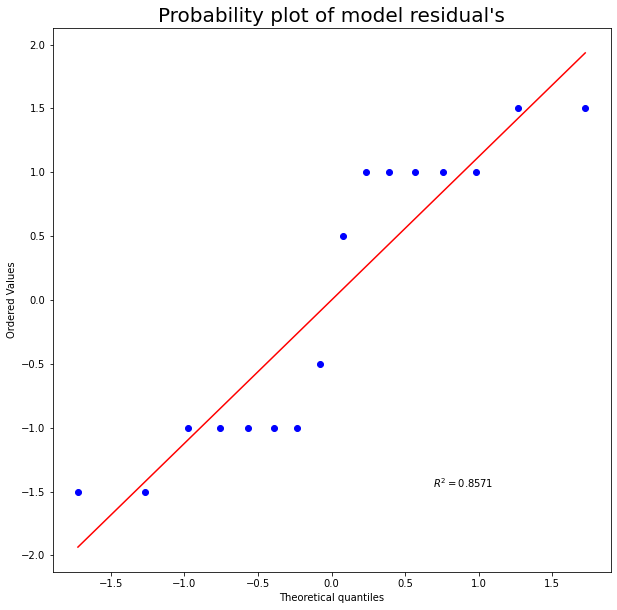

In [17]:
# Residual Analysis
# normal check

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(res.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of model residual's", fontsize= 20)
ax.set

plt.show()

The above probably plot shows that the residuals are not normal 

In [18]:
# Homogeneity of Variance check for Factor A
# if the p value is small, reject H0 that the residuals have equal variance
# if the p value is large, cannot reject H0

stats.levene(df['SF'][df['A'] == -1],
             df['SF'][df['A'] == 1])
            

LeveneResult(statistic=1.6355140186915889, pvalue=0.22173473626669127)

Since p value is very large, we fail to reject that factor A has equal variance

In [19]:
# Homogeneity of Variance check for Factor B
# if the p value is small, reject H0 that the residuals have equal variance
# if the p value is large, cannot reject H0

stats.levene(df['SF'][df['B'] == -1],
             df['SF'][df['B'] == 1])

LeveneResult(statistic=2.6872037914691944, pvalue=0.12342616026098481)

Since p value is very large, we fail to reject that factor A has equal variance

In [20]:
# Homogeneity of Variance check for Factor C
# if the p value is small, reject H0 that the residuals have equal variance
# if the p value is large, cannot reject H0

stats.levene(df['SF'][df['C'] == -1],
             df['SF'][df['C'] == 1])

LeveneResult(statistic=0.0231023102310231, pvalue=0.8813599678134876)

The p value of the Levene is very large. We don't have evidence to conclude that the variances from different primer type are different

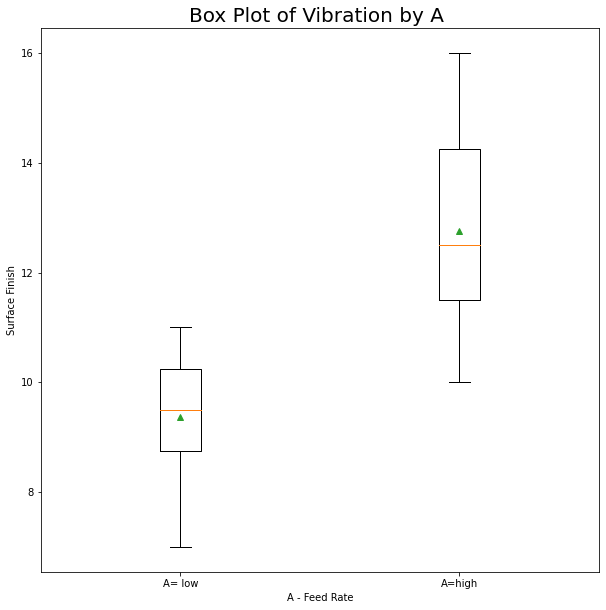

In [22]:
# Box plots by factor A'
# If the IRQ=75% quartitle - 25% quartile are very different, then question the constant variance assumption
# If the F test p value is very small, we reject H0 and can use this box plot to identify the best factor level

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Vibration by A ", fontsize= 20)
ax.set

data2 = [df['SF'][df['A'] == -1],
             df['SF'][df['A'] == 1]]


ax.boxplot(data2,
           labels= ['A= low', 'A=high'],
           showmeans= True)

plt.xlabel("A - Feed Rate")
plt.ylabel("Surface Finish")

plt.show()

There is not much difference in variation. The largest adhesion strength is due to type 2 primer type.

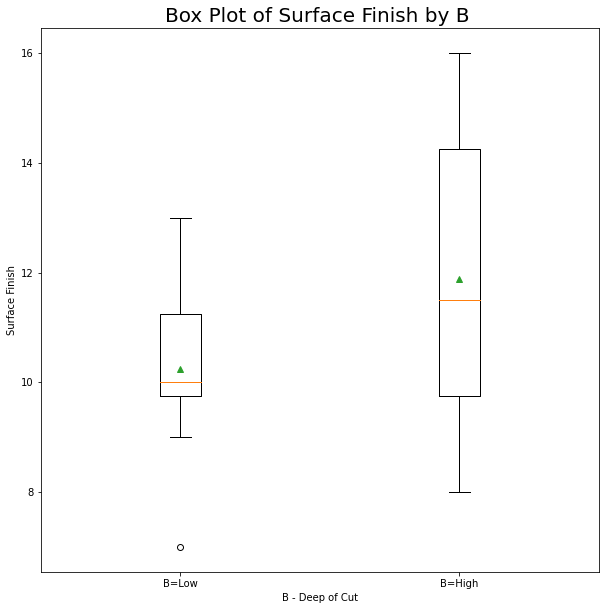

In [21]:
# Box plots by factor B
# same instruction as the previous factor 

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Surface Finish by B ", fontsize= 20)
ax.set

data2 = [df['SF'][df['B'] == -1],
         df['SF'][df['B'] == +1]]


ax.boxplot(data2,
           labels= ['B=Low', 'B=High'],
           showmeans= True)

plt.xlabel("B - Deep of Cut")
plt.ylabel("Surface Finish")

plt.show()

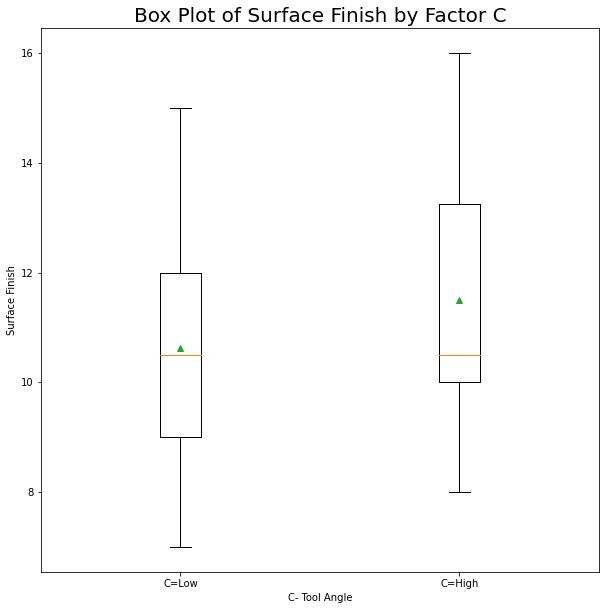

In [23]:
# Box plots by factor C
# same instruction as the previous factor Primer types

fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

ax.set_title("Box Plot of Surface Finish by Factor C", fontsize= 20)
ax.set

data2 = [df['SF'][df['C'] == -1],
         df['SF'][df['C'] == +1]]


ax.boxplot(data2,
           labels= ['C=Low', 'C=High'],
           showmeans= True)

plt.xlabel("C- Tool Angle")
plt.ylabel("Surface Finish")

plt.show()

There is not much difference in variation by application method. The largest adhesion strength is due to spraying method.

In [25]:
# testing the random order for collecting observations 
# Minitab calls the order variable, run order
# the following code generate a random order
# you should conduct your experiments using the random order generated
# for example, the first number is 5, it means that you will run the setting 5 in the experimentation table
# observation label 5 is primier type 3 and application method 2 (spraying)
# the run observation 11 and so on until all observations are collected
# import random (see the first cell)
N = len(Y)
#c = list(range(0, N))
#xorder = random.sample(c, N) # this should be replaced by the exact run order if the random order is not used

order=df[['run_order']]
order=order.to_numpy() 
#the following step reduces the index in run_order by 1 so that the python index from 0 can function properly
order2=np.zeros(N) #order 2 is a list of zero
for i in range(N):
    order2[i]=order[i]-1 #assign the value of element in an array into the list


print('order of observations/residuals is')
print(order2)
# convert the array into a list for indexing
#order=order.reshape((1,N))
#order=order.tolist()
#print(order)



order of observations/residuals is
[ 7. 11.  8.  6.  3. 12. 10.  2. 15.  4.  0. 14. 13.  1.  5.  9.]


In [26]:
res.resid

0     1.0
1    -1.0
2    -1.0
3    -1.5
4     0.5
5    -1.5
6     1.0
7     1.0
8    -1.0
9     1.0
10    1.0
11    1.5
12   -0.5
13    1.5
14   -1.0
15   -1.0
dtype: float64

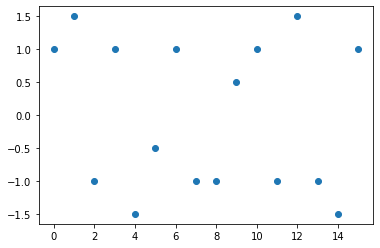

In [27]:
# Use the run order to reflect the sequence that we collected the data 
# if there is no pattern in the scatter plot, then don't reject independence assumption

eij=res.resid

x = range(0,N) # from the first collected obs to the last in order
y = eij[order2] # assign run order (see the previous code box)

plt.scatter(x, y)

The random order from the scatter plot above shows no pattern. If the data in the first half of the experiments are lower than 0 while those of the second half are above 0. Then there is a bias in data collection. If the residuals are small in the beginning but graduately increase. Or vice versa. It is a concern as well. In these cases, independence assumption is violated.

In [28]:
#running the reduced model with only A and B since C is not significant

X=xxpd[['x1', 'x2', 'x1x2']]
X = sm.add_constant(X)
model = sm.OLS(Y, X)
res=model.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                     SF   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     8.709
Date:                Fri, 22 Oct 2021   Prob (F-statistic):            0.00243
Time:                        13:05:33   Log-Likelihood:                -27.529
No. Observations:                  16   AIC:                             63.06
Df Residuals:                      12   BIC:                             66.15
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0625      0.390     28.343      0.0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=16



In [29]:
# fit the regression 
Y=df[['SF']]
regr=LinearRegression()
regr.fit(X,Y)
Yhat=regr.predict(X)
Yhat

array([[ 9.25],
       [11.25],
       [ 9.5 ],
       [14.25],
       [ 9.25],
       [11.25],
       [ 9.5 ],
       [14.25],
       [ 9.25],
       [11.25],
       [ 9.5 ],
       [14.25],
       [ 9.25],
       [11.25],
       [ 9.5 ],
       [14.25]])

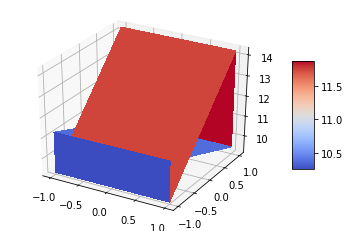

In [30]:
# 3 D plot of reduced model A, B and response SF in Z axis
# Z axis is the predicted observation Yhat

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x1=df['A']
x2=df['B']
x1, x2 = np.meshgrid(x1, x2)

# Plot the surface.
surf = ax.plot_surface(x1, x2, Yhat, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

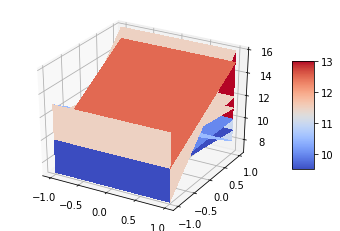

In [31]:
# 3 D plot of reduced model A, B and response SF in Z axis
# Z axis is the raw observation Y

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

x1=df['A']
x2=df['B']
x1, x2 = np.meshgrid(x1, x2)

# Plot the surface.
surf = ax.plot_surface(x1, x2, Y, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
#ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
#ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()